In [685]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [1090]:
df = pd.read_csv("krisha.csv", sep=';')
df.index = pd.to_datetime(df.data)
df = df.iloc[:, 1:]
df = df.drop_duplicates()
df = df.sort_index()
df

,currency,usdpercent,usd,tngpercent,tng
data,,,,,
2008-01-04,1 USD = 121.65 KZT,-1.08%,2 387 $/м2,-1.08%,290 400 ₸/м2
2008-02-09,1 USD = 121.65 KZT,1.59%,1 981 $/м2,1.59%,241 000 ₸/м2
2008-02-12,1 USD = 121.65 KZT,-1.11%,1 960 $/м2,-1.11%,238 400 ₸/м2
2008-02-26,1 USD = 121.65 KZT,-0.84%,2 601 $/м2,-0.84%,316 400 ₸/м2
2008-03-18,1 USD = 121.65 KZT,-1.27%,2 478 $/м2,-1.27%,301 400 ₸/м2
...,...,...,...,...,...
2020-09-09,1 USD = 425.74 KZT,-0.38%,1 047 $/м2,0.9%,445 900 ₸/м2
2020-10-06,1 USD = 398.59 KZT,-3.61%,1 069 $/м2,-6.13%,426 700 ₸/м2
2020-11-03,1 USD = 393.60 KZT,-2.44%,1 079 $/м2,3.2%,434 400 ₸/м2


In [1091]:
df['usd'] = df['usd'].apply(lambda x: float(x.replace('$/м2', '').replace(' ', '')))
df['tng'] = df['tng'].apply(lambda x: float(x.replace('₸/м2', '').replace(' ', '')))
df

,currency,usdpercent,usd,tngpercent,tng
data,,,,,
2008-01-04,1 USD = 121.65 KZT,-1.08%,2387.0,-1.08%,290400.0
2008-02-09,1 USD = 121.65 KZT,1.59%,1981.0,1.59%,241000.0
2008-02-12,1 USD = 121.65 KZT,-1.11%,1960.0,-1.11%,238400.0
2008-02-26,1 USD = 121.65 KZT,-0.84%,2601.0,-0.84%,316400.0
2008-03-18,1 USD = 121.65 KZT,-1.27%,2478.0,-1.27%,301400.0
...,...,...,...,...,...
2020-09-09,1 USD = 425.74 KZT,-0.38%,1047.0,0.9%,445900.0
2020-10-06,1 USD = 398.59 KZT,-3.61%,1069.0,-6.13%,426700.0
2020-11-03,1 USD = 393.60 KZT,-2.44%,1079.0,3.2%,434400.0


In [1199]:
train_size = 0.8
test_size = 0.9
ranges_test = int(df[['tng']].shape[0]*train_size)
ranges_val = int(df[['tng']].shape[0]*test_size)

train = df[['tng']].iloc[:ranges_test]
test = df[['tng']].iloc[ranges_val:]
val = df[['tng']].iloc[ranges_test:ranges_val]

In [1200]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_val = scaler.transform(val)
print(scaled_train[-5:])

[[0.504 ]
 [0.5004]
 [0.5808]
 [0.4884]
 [0.4852]]


In [1305]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=1, shuffle=True)

In [1306]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

In [1332]:
model = Sequential()
model.add(LSTM(5,activation="relu",input_shape=(n_input,n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer="nadam",loss="mse")

model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_135 (Dense)            (None, 10)                60        
_________________________________________________________________
dropout_21 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 10)                110       
_________________________________________________________________
dropout_22 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_138 (Dense)            (None, 1)               

In [1333]:
validation_gen = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [1334]:
model.fit_generator(generator, validation_data=validation_gen, epochs=50)

Epoch 1/50
363/363 [==============================] - 11s 31ms/step - loss: 0.0405 - val_loss: 0.0125
Epoch 2/50
363/363 [==============================] - 2s 7ms/step - loss: 0.0138 - val_loss: 0.0061
Epoch 3/50
363/363 [==============================] - 2s 6ms/step - loss: 0.0125 - val_loss: 0.0028
Epoch 4/50
363/363 [==============================] - 2s 7ms/step - loss: 0.0115 - val_loss: 0.0033
Epoch 5/50
363/363 [==============================] - 3s 7ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 6/50
363/363 [==============================] - 3s 7ms/step - loss: 0.0069 - val_loss: 0.0105
Epoch 7/50
363/363 [==============================] - 3s 7ms/step - loss: 0.0117 - val_loss: 0.0025
Epoch 8/50
363/363 [==============================] - 3s 7ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 9/50
363/363 [==============================] - 3s 7ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 10/50
363/363 [==============================] - 3s 7ms/step - loss: 0.0083 - val_loss: 0.01

<AxesSubplot:title={'center':'Эпоха мен жоғалту қисығының графигі'}>

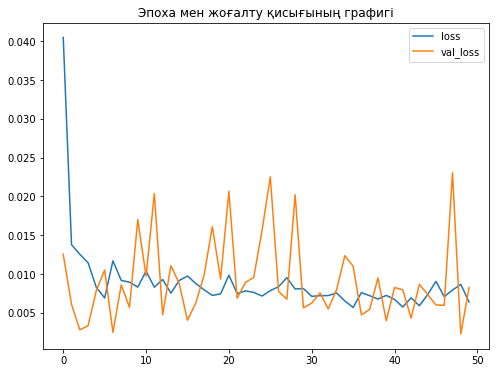

In [1335]:
pd.DataFrame(model.history.history).plot(title="Эпоха мен жоғалту қисығының графигі")

In [1336]:
weeks = 20

In [1337]:
test_prediction = []
first_eval_batch = scaled_test[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)-n_input):
    current_pred = model.predict(scaled_test[i:i+n_input].reshape(1,n_input,n_features))[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

for i in range(n_input+weeks):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
test_prediction

[array([0.55332726], dtype=float32),
 array([0.5616656], dtype=float32),
 array([0.5624832], dtype=float32),
 array([0.5537476], dtype=float32),
 array([0.5595042], dtype=float32),
 array([0.5633115], dtype=float32),
 array([0.56336474], dtype=float32),
 array([0.55473316], dtype=float32),
 array([0.5636521], dtype=float32),
 array([0.5652149], dtype=float32),
 array([0.56979173], dtype=float32),
 array([0.57302535], dtype=float32),
 array([0.59057057], dtype=float32),
 array([0.5773238], dtype=float32),
 array([0.5886783], dtype=float32),
 array([0.5923681], dtype=float32),
 array([0.6018965], dtype=float32),
 array([0.61969006], dtype=float32),
 array([0.6412898], dtype=float32),
 array([0.6469554], dtype=float32),
 array([0.6449757], dtype=float32),
 array([0.6450655], dtype=float32),
 array([0.6588257], dtype=float32),
 array([0.6584706], dtype=float32),
 array([0.6628729], dtype=float32),
 array([0.65684634], dtype=float32),
 array([0.6689945], dtype=float32),
 array([0.6696497], 

In [1338]:
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([353231.8156004 , 355316.39864445, 355520.79787254, 353336.89858913,
       354776.05273724, 355727.87930965, 355741.1860466 , 353583.28928947,
       355813.02454472, 356203.71809006, 357347.93355465, 358156.33645058,
       362542.6422596 , 359230.94859123, 362069.57509518, 362992.03147888,
       365374.13110733, 369822.51515388, 375222.44265079, 376638.84272575,
       376143.93045902, 376166.37160778, 379606.42387867, 379517.64276028,
       380618.22762489, 379111.58611774, 382148.62158298, 382312.43004799,
       382323.0992794 , 377555.86018562, 380398.07786942, 379309.02650356,
       380269.07851696, 382082.17730522, 385872.7793932 , 386440.4689312 ,
       386442.59979725, 386378.31618786, 382558.03098679, 381127.11718082,
       377796.1712122 , 353795.586133  , 350178.23984623, 347086.57672405,
       344238.93501759, 341609.87844467, 339330.00078201, 338288.37981224,
       337473.46510887, 336838.80975246, 336363.35840225, 336027.90346146,
       335810.61472893, 3

In [1339]:
time_series_array = test.index
for k in range(0, weeks):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(7))
time_series_array

DatetimeIndex(['2019-06-26', '2019-07-08', '2019-07-17', '2019-07-31',
               '2019-08-05', '2019-08-21', '2019-08-28', '2019-09-01',
               '2019-09-10', '2019-09-18', '2019-09-25', '2019-10-04',
               '2019-10-07', '2019-10-16', '2019-10-23', '2019-11-13',
               '2019-11-27', '2019-12-06', '2019-12-18', '2019-12-25',
               '2020-01-01', '2020-01-04', '2020-01-07', '2020-01-15',
               '2020-01-22', '2020-02-26', '2020-03-06', '2020-03-09',
               '2020-03-25', '2020-04-03', '2020-04-15', '2020-04-22',
               '2020-04-29', '2020-05-02', '2020-05-13', '2020-05-20',
               '2020-06-24', '2020-07-22', '2020-07-29', '2020-08-07',
               '2020-08-19', '2020-09-09', '2020-10-06', '2020-11-03',
               '2020-12-02', '2020-12-08', '2020-12-15', '2020-12-22',
               '2020-12-29', '2021-01-05', '2021-01-12', '2021-01-19',
               '2021-01-26', '2021-02-02', '2021-02-09', '2021-02-16',
      

In [1358]:
df_forecast = pd.DataFrame(columns=["tng","predicted"], index=time_series_array)
df_forecast

,tng,predicted
data,,
2019-06-26,NaN,NaN
2019-07-08,NaN,NaN
2019-07-17,NaN,NaN
2019-07-31,NaN,NaN
2019-08-05,NaN,NaN
...,...,...
2021-03-30,NaN,NaN
2021-04-06,NaN,NaN
2021-04-13,NaN,NaN


In [1359]:
df_forecast.loc[:,"predicted"] = true_prediction[:,0] * scaled_test.mean() / (scaled_train.mean()*2)
df_forecast.iloc[:train["tng"].shape[0],0] = test["tng"]
df_forecast

,tng,predicted
data,,
2019-06-26,379300.0,402853.801636
2019-07-08,391100.0,405231.226792
2019-07-17,381200.0,405464.340012
2019-07-31,385800.0,402973.646678
2019-08-05,371300.0,404614.973121
...,...,...
2021-03-30,NaN,382373.385334
2021-04-06,NaN,382364.905091
2021-04-13,NaN,382358.872052


<AxesSubplot:title={'center':'pred'}, xlabel='data'>

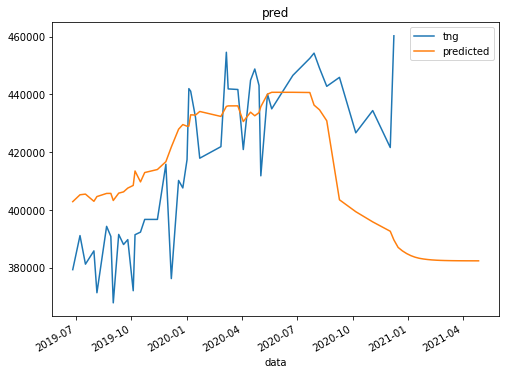

In [1360]:
df_forecast.plot(title="pred")

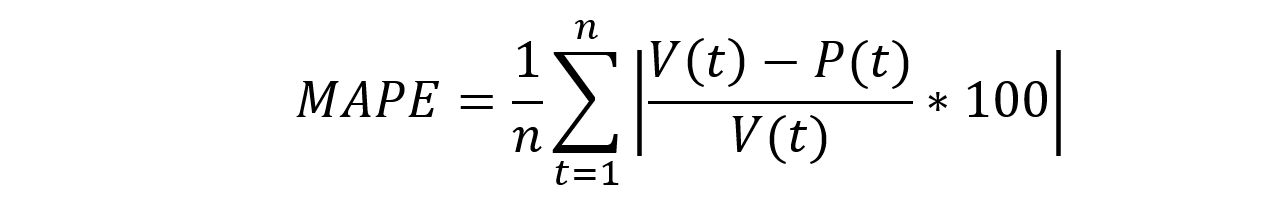

In [1361]:
MAPE = np.mean(np.abs(np.array(df_forecast["tng"][:5]) - np.array(df_forecast["predicted"][:5]))/np.array(df_forecast["tng"][:5]))
print("MAPE = " + str(MAPE*100) + " %")

MAPE is 5.922443927867242 %


In [1362]:
sum_errs = np.sum((np.array(df_forecast["tng"][:5]) - np.array(df_forecast["predicted"][:5]))**2)
sum_errs

2748052912.6590815

In [1363]:
stdev = np.sqrt(1/(5-2) * sum_errs)
stdev

30265.783280018164

In [1364]:
interval = 1.96 * stdev
interval

59320.9352288356

In [1365]:
df_forecast["predicted минималды"] = df_forecast["predicted"] - interval
df_forecast["predicted максималды"] = df_forecast["predicted"] + interval
df_forecast

,tng,predicted,predicted минималды,predicted максималды
data,,,,
2019-06-26,379300.0,402853.801636,343532.866407,462174.736865
2019-07-08,391100.0,405231.226792,345910.291563,464552.162021
2019-07-17,381200.0,405464.340012,346143.404783,464785.275241
2019-07-31,385800.0,402973.646678,343652.711449,462294.581906
2019-08-05,371300.0,404614.973121,345294.037892,463935.908350
...,...,...,...,...
2021-03-30,NaN,382373.385334,323052.450105,441694.320563
2021-04-06,NaN,382364.905091,323043.969862,441685.840319
2021-04-13,NaN,382358.872052,323037.936823,441679.807281


In [1366]:
df_forecast["Модель дәлдігі"] = round((float(1-MAPE)*100),2)
df_forecast

,tng,predicted,predicted минималды,predicted максималды,Модель дәлдігі
data,,,,,
2019-06-26,379300.0,402853.801636,343532.866407,462174.736865,94.08
2019-07-08,391100.0,405231.226792,345910.291563,464552.162021,94.08
2019-07-17,381200.0,405464.340012,346143.404783,464785.275241,94.08
2019-07-31,385800.0,402973.646678,343652.711449,462294.581906,94.08
2019-08-05,371300.0,404614.973121,345294.037892,463935.908350,94.08
...,...,...,...,...,...
2021-03-30,NaN,382373.385334,323052.450105,441694.320563,94.08
2021-04-06,NaN,382364.905091,323043.969862,441685.840319,94.08
2021-04-13,NaN,382358.872052,323037.936823,441679.807281,94.08


<AxesSubplot:xlabel='data'>

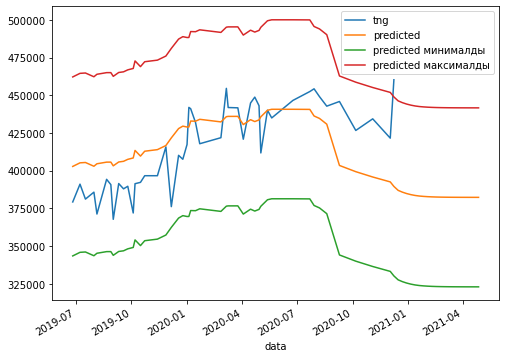

In [1367]:
df_forecast.iloc[:,:4].plot()

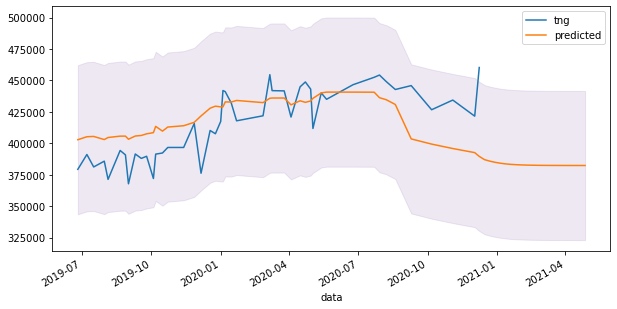

In [1368]:
fig= plt.figure(figsize=(10,5))
df_forecast["tng"].plot()
df_forecast["predicted"].plot()
plt.fill_between(df_forecast.index,df_forecast["predicted минималды"],df_forecast["predicted максималды"],color="indigo",alpha=0.09,label="")
plt.legend()
plt.show()